# Feature Selection (on Tileset7) - July 2017
Created:  17 July 2018 <br>
Last update: 17 july 2018


### Using random forest  (extra forest), existing features can be ranked in order of contribution
(This notebook follows the feature selection notebook from Pierluggi)

Note that this is a different approach then PCA (see notebook 'realxtals1-dimensionality1').
In PCA, the data is transformed onto the 'natural axis' of the data (its eigen vectors) and the top N of these are used, while in feature selection the existing features are being assessed based on their contribution to a classifier.

See e.g.:
* https://www.quora.com/What-is-the-difference-between-principal-component-analysis-PCA-and-feature-selection-in-machine-learning-Is-PCA-a-means-of-feature-selection
* https://stats.stackexchange.com/questions/182711/principal-component-analysis-vs-feature-selection



## 1. Imports

In [1]:
# this will remove warnings messages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# import
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder

import imgutils

In [2]:
# Re-run this cell if you altered imgutils
import importlib
importlib.reload(imgutils)

<module 'imgutils' from 'C:\\JADS\\SW\\Grad Proj\\sources\\imgutils.py'>

## 2. Import Crystal Image Data & Statistics
The data was labeled and exported to csv in the notebook realxtals1_dataeng1.ipynb

#### About the data:
The CSV contains the image files, slice information (sub-images) and associated statistics, which are the features for which a classifier needs to be found. 

The goal is to find the clustering in feature-space and use those to categorize the images. For this particular dataset, a single statistics could be used to label into three classes:<br>

A = subimage contains no crystal, <br>
B = part of subimage contains crystal, <br>
C = (most of) subimage contains crystal

But the labels have been added here for analyses, eventually the data will be unlabelled.

 



Import data:

In [3]:
df = pd.read_csv('../data/Crystals_Apr_12/Tileset7-2.csv', sep=';')
df.head()

,Unnamed: 0,filename,s_y,s_x,n_y,n_x,alias,img_mean,img_std,img_kurtosis,img_skewness,img_mode,img_std2,|img_mean|,|img_std|,|img_kurtosis|,|img_skewness|,|img_mode|,|img_std2|,class
0,0,..\data\Crystals_Apr_12\Tileset7\Tile_001-001-...,0,0,4,4,img0_0-0,8955.557637,489.754848,4.163737,0.107415,8964.037109,0.054687,0.615795,-0.100998,0.082333,0.471479,0.204925,-0.122335,A
1,1,..\data\Crystals_Apr_12\Tileset7\Tile_001-001-...,0,1,4,4,img0_0-1,8883.137305,501.739963,6.528225,-0.146746,8921.014648,0.056482,0.289248,-0.079451,0.504401,0.090672,0.006384,-0.095243,A
2,2,..\data\Crystals_Apr_12\Tileset7\Tile_001-001-...,0,2,4,4,img0_0-2,8786.996070,327.512136,1.323241,-0.110828,8753.567871,0.037272,-0.144258,-0.392677,-0.424704,0.144487,-0.766354,-0.385181,A
3,3,..\data\Crystals_Apr_12\Tileset7\Tile_001-001-...,0,3,4,4,img0_0-3,8679.430512,273.673569,0.112149,0.008591,8682.245605,0.031531,-0.629277,-0.489467,-0.640887,0.323411,-1.095494,-0.471832,A
4,4,..\data\Crystals_Apr_12\Tileset7\Tile_001-001-...,1,0,4,4,img0_1-0,8982.867158,380.410977,0.168520,0.033678,8987.800781,0.042349,0.738935,-0.297575,-0.630825,0.360999,0.314590,-0.308566,A


## 3. Quick visual inspection of the 'feature space'

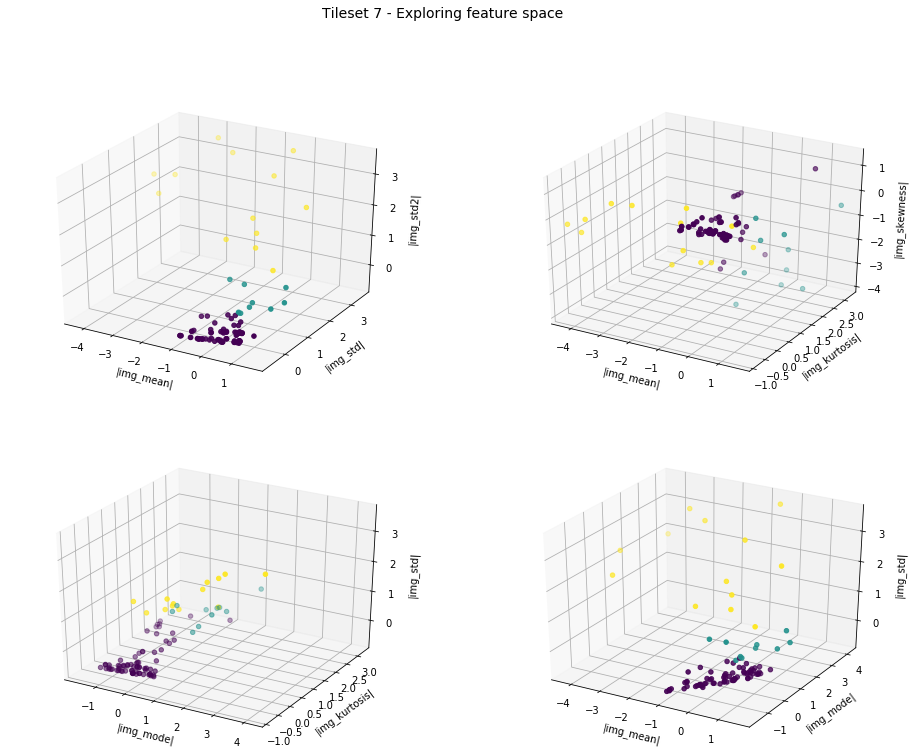

In [4]:
# plot it in 3 dimensions, choosing some stat combinations
fig0 = plt.figure(figsize=(16, 12))
plt.suptitle("Tileset 7 - Exploring feature space",fontsize=14)

# trick to convert category labels into color codes
color = pd.DataFrame(df['class'].astype('category'))['class'].cat.codes

def scatter_3d(ax, df, feat1, feat2, feat3, colors):
    ax.scatter(df[feat1], df[feat2], df[feat3], c=colors)
    ax.set_xlabel(feat1)
    ax.set_ylabel(feat2)
    ax.set_zlabel(feat3)


ax = fig0.add_subplot(221, projection='3d')
scatter_3d(ax, df, '|img_mean|', '|img_std|', '|img_std2|', color)

ax = fig0.add_subplot(222, projection='3d')
scatter_3d(ax, df, '|img_mean|', '|img_kurtosis|', '|img_skewness|', color)

ax = fig0.add_subplot(223, projection='3d')
scatter_3d(ax, df, '|img_mode|', '|img_kurtosis|', '|img_std|', color)

ax = fig0.add_subplot(224, projection='3d')
scatter_3d(ax, df, '|img_mean|', '|img_mode|', '|img_std|', color)

plt.show()

From visual inspection of these graphs, I would expect the std, std2 and kurtosis to be the most important features (they seem like the most seperating ones, though the mean has quite a big variance). Also look at the histograms (to get idea of the variance):

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B7F29B0>,
      dtype=object)

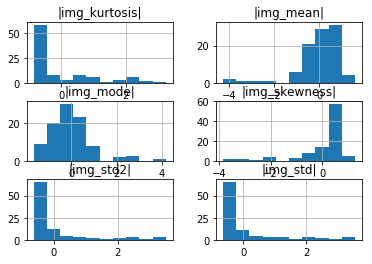

In [5]:
df.hist(['|img_mean|','|img_std|', '|img_std2|', '|img_kurtosis|', '|img_skewness|','|img_mode|'])

## 4. Assess feature imporance (using extra trees classifier)

(sort of random forest, an ensemble method that will create classifiers based on random subsets) 


### First vectorize the data:

In [6]:
# convert labels into values
le = LabelEncoder()
df["|class|"] = le.fit_transform(df["class"])

In [7]:
# convert into X Y vectors:
feature_cols = ['|img_std|', '|img_mean|','|img_skewness|', '|img_mode|', '|img_kurtosis|', '|img_std2|']
X = df.loc[:,feature_cols]
y = df.loc[:,'|class|']

### Then generate the classifier 'extra tries' and extract the importances
(a la Pierluggi)

In [8]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=500,random_state=0)
forest.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [9]:
# Extracting feature importance:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d '%s' (%f)" % (f + 1, indices[f], feature_cols[indices[f]], importances[indices[f]]))


Feature ranking:
1. feature 5 '|img_std2|' (0.331023)
2. feature 0 '|img_std|' (0.310544)
3. feature 2 '|img_skewness|' (0.111690)
4. feature 3 '|img_mode|' (0.100443)
5. feature 4 '|img_kurtosis|' (0.082564)
6. feature 1 '|img_mean|' (0.063736)


Hmmm, I am surprised that skewness scores higher than kurtosis.

### Visually inspect the important features

Let's make some plots based on the first 3 most important ones


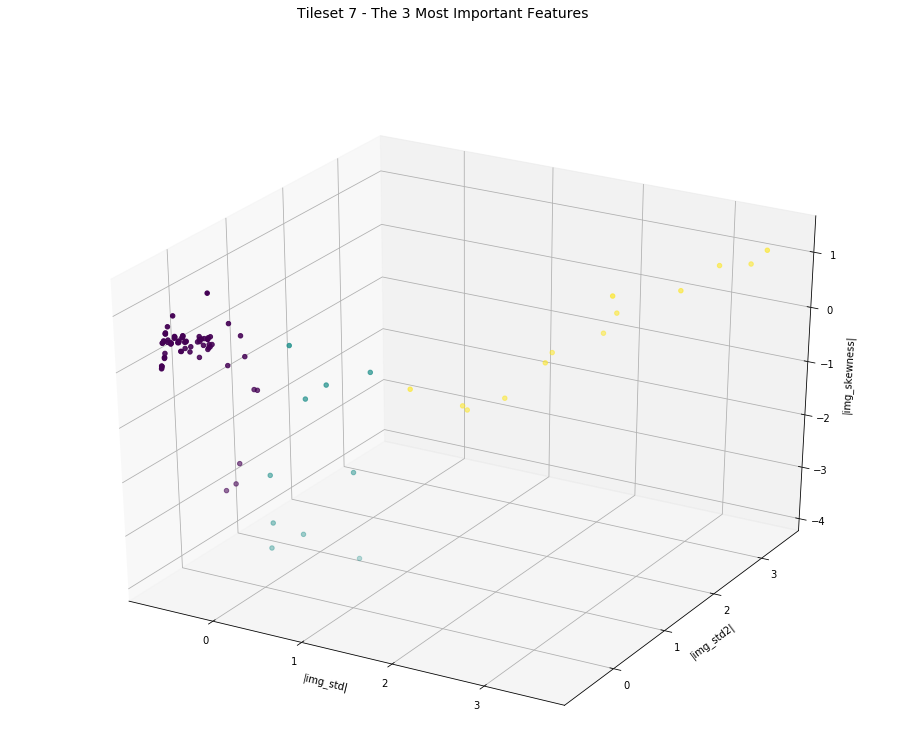

In [10]:
fig0 = plt.figure(figsize=(16, 12))
plt.suptitle("Tileset 7 - The 3 Most Important Features",fontsize=14)
ax = fig0.add_subplot(111, projection='3d')
scatter_3d(ax, df, '|img_std|', '|img_std2|', '|img_skewness|', color)

Indeed with these three variables they are clearly separatable.

But I think with the kurtosis or some of the others it would also work, as long as std and std2 are in there. So let's compare


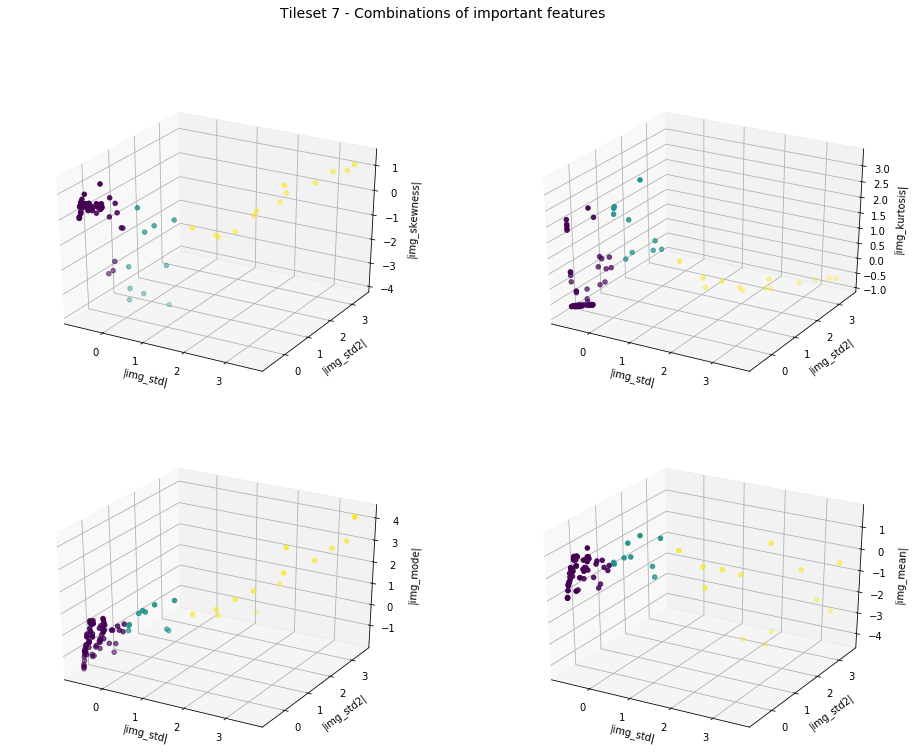

In [11]:
fig0 = plt.figure(figsize=(16, 12))
plt.suptitle("Tileset 7 - Combinations of important features",fontsize=14)
ax = fig0.add_subplot(221, projection='3d')
scatter_3d(ax, df, '|img_std|', '|img_std2|', '|img_skewness|', color)
ax = fig0.add_subplot(222, projection='3d')
scatter_3d(ax, df, '|img_std|', '|img_std2|', '|img_kurtosis|', color)
ax = fig0.add_subplot(224, projection='3d')
scatter_3d(ax, df, '|img_std|', '|img_std2|', '|img_mean|', color)
ax = fig0.add_subplot(223, projection='3d')
scatter_3d(ax, df, '|img_std|', '|img_std2|', '|img_mode|', color)

Indeed the std and std are leading, but you need a 3rd dimension for separation. Looking at the importances this is maybe not so surprising, as skewness, kurtosis, mode and mean are rather close.

## 5. Comparing result with Dimensionality Reduction Techniques

(this has been analyzed in realxtals1-dimensionality1. To keep this notebook self-contained and independend, we do the dimensionality reduction here instead of exporting from the other notebook)


In [12]:
from sklearn import manifold, decomposition, datasets, random_projection

### First assess PCA and IsoMap with 3 components
(looked most promising in dimensionality assessment)

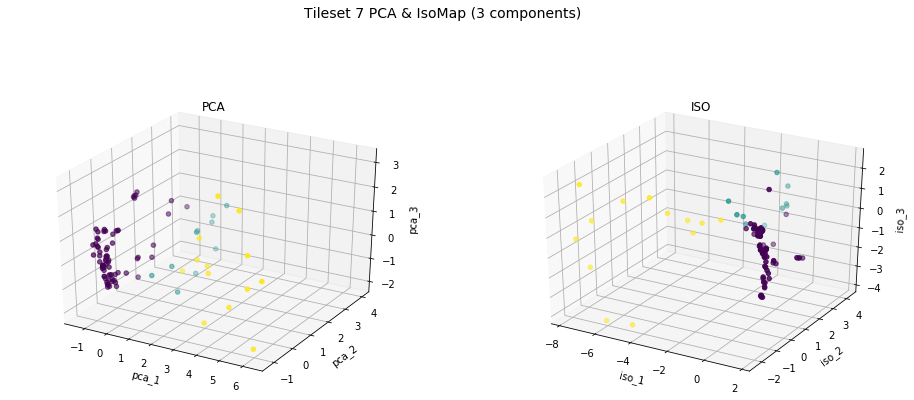

In [13]:
# Create graph
fig0 = plt.figure(figsize=(16, 12))
plt.suptitle("Tileset 7 PCA & IsoMap (3 components)",fontsize=14)

# PCA (or SVD, which is almost the same)
title = 'PCA'
fieldnames = ['pca_1','pca_2','pca_3']
pca = decomposition.TruncatedSVD(n_components=3)
X_fit = pca.fit_transform(X)
df_pca = pd.DataFrame(X_fit[:,0:3], columns=fieldnames)
ax = fig0.add_subplot(221, projection='3d', title=title)
scatter_3d(ax, df_pca, fieldnames[0],fieldnames[1],fieldnames[2], color)
                                                
# Iso Map
title = 'ISO'
fieldnames = ['iso_1','iso_2','iso_3']
iso = manifold.Isomap(n_neighbors=10, n_components=3)
X_fit = iso.fit_transform(X)
df_pca = pd.DataFrame(X_fit[:,0:3], columns=fieldnames)
ax = fig0.add_subplot(222, projection='3d', title=title)
scatter_3d(ax, df_pca, fieldnames[0],fieldnames[1],fieldnames[2], color)


### Comparing with range of dimensionality reduction techniques
Let's assess more methods just as in the 'dimensionality notebook', but using three components


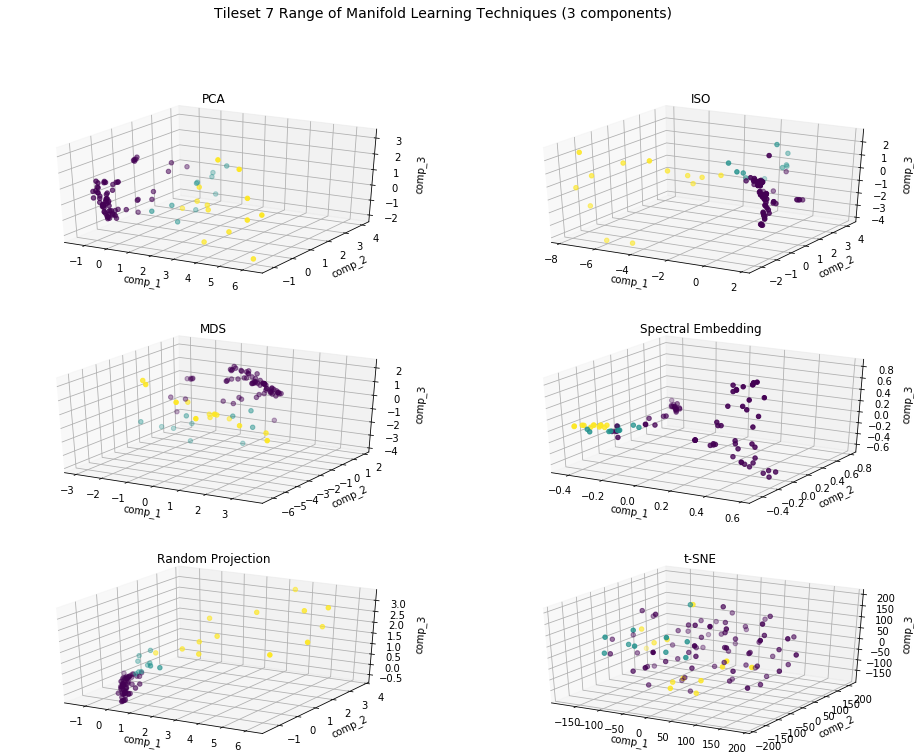

In [14]:
# Create graph
fig0 = plt.figure(figsize=(16, 12))
plt.suptitle("Tileset 7 Range of Manifold Learning Techniques (3 components)",fontsize=14)

fieldnames = ['comp_1','comp_2','comp_3']

# PCA (or SVD, which is almost the same)
title = 'PCA'
pca = decomposition.TruncatedSVD(n_components=3)
X_fit = pca.fit_transform(X)
df_fit = pd.DataFrame(X_fit[:,0:3], columns=fieldnames)
ax = fig0.add_subplot(321, projection='3d', title=title)
scatter_3d(ax, df_fit, fieldnames[0],fieldnames[1],fieldnames[2], color)
                                                                                              
# Iso Map
title = 'ISO'
iso = manifold.Isomap(n_neighbors=10, n_components=3)
X_fit = iso.fit_transform(X)
df_fit = pd.DataFrame(X_fit[:,0:3], columns=fieldnames)
ax = fig0.add_subplot(322, projection='3d', title=title)
scatter_3d(ax, df_fit, fieldnames[0],fieldnames[1],fieldnames[2], color)

# MDS
title = 'MDS'
mds = manifold.MDS(n_components=3, max_iter=100, n_init=1)
X_fit = mds.fit_transform(X)
df_fit = pd.DataFrame(X_fit[:,0:3], columns=fieldnames)
ax = fig0.add_subplot(323, projection='3d', title=title)
scatter_3d(ax, df_fit, fieldnames[0],fieldnames[1],fieldnames[2], color)

# Spectral embedding
title = 'Spectral Embedding'
se = manifold.SpectralEmbedding(n_components=3, n_neighbors=10)
X_fit = se.fit_transform(X)
df_fit = pd.DataFrame(X_fit[:,0:3], columns=fieldnames)
ax = fig0.add_subplot(324, projection='3d', title=title)
scatter_3d(ax, df_fit, fieldnames[0],fieldnames[1],fieldnames[2], color)

# Random Projection
title = 'Random Projection'
rp = random_projection.SparseRandomProjection(n_components=3, random_state=42)
X_fit = rp.fit_transform(X)
df_fit = pd.DataFrame(X_fit[:,0:3], columns=fieldnames)
ax = fig0.add_subplot(325, projection='3d', title=title)
scatter_3d(ax, df_fit, fieldnames[0],fieldnames[1],fieldnames[2], color)

# t-SNE
title = 't-SNE'
tsne = manifold.TSNE(n_components=3, init='pca', random_state=42)
X_fit = tsne.fit_transform(X)
df_fit = pd.DataFrame(X_fit[:,0:3], columns=fieldnames)
ax = fig0.add_subplot(326, projection='3d', title=title)
scatter_3d(ax, df_fit, fieldnames[0],fieldnames[1],fieldnames[2], color)



## 6. More analysis?

## 7. Conclusions
* From visually inspecting these graphs and comparing those to the 'feature selection method', the 'feature selection' looks more separatable.
* However, the feature selection method requires labeled data in order to train the classifier, while the manifest learning methods does not require labelling

## 8. Next Steps:
- Try unsupervised learning on this data set (maybe first apply a manifold learning technique to optimize the data?) 
- Repeat this notebook on harder dataset


Michael Janus, 17 July 2018